In [1]:
import cartopy
import glob
from haversine import haversine, Unit
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys


from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib notebook

sys.path.append("../marinetraffic/")

from vesseltracks import read_vesseltracks_file

In [2]:
known_windfarms = pd.read_excel("../../data/windfarms/windfarms-complete_turbines.ods", engine="odf")
known_windfarms.set_index("index", inplace=True)
known_windfarms.turbine_installation_vessel = known_windfarms.turbine_installation_vessel.apply(lambda x : [i.lower().lstrip().replace(" ", "-") for i in str(x).split(",")])

In [65]:
def get_cluster_coord(basedir, min_locations=6, verbose=False):
    for vesseldir in glob.glob(os.path.join(basedir, "*")):
        vesselkey = os.path.basename(vesseldir)
        for clusterdir in glob.glob(os.path.join(vesseldir, "cluster_*")):
            clustername = os.path.basename(clusterdir)
            if (n_locations := len(glob.glob(os.path.join(clusterdir, "*location_*.csv")))) < 6:
                if verbose:
                    print(f"only {n_locations} single locations available at {clusterdir}, skipping")
                continue
            if os.path.isfile(cluster_fpath := os.path.join(clusterdir, f"{vesselkey}_{clustername}.csv")):
                cluster = read_vesseltracks_file(cluster_fpath)
                lat_mean = cluster.latitude.mean()
                lon_mean = cluster.longitude.mean()
                yield (vesselkey, clustername, lat_mean, lon_mean, cluster_fpath)

def match_cluster_windfarm(clustered_vesseltracks_dir, windfarms, lower_bound=0.08, upper_bound=0.08, verbose=False):
    match_n = 1
    for (vesselkey, clustername, cluster_lat, cluster_lon, cluster_fpath) in get_cluster_coord(clustered_vesseltracks_dir, verbose=verbose):
        vesselname = vesselkey.split("_")[-1]
        for windfarm in windfarms.itertuples():
            lat_lower = windfarm.latitude - lower_bound
            lat_upper = windfarm.latitude + upper_bound
            lon_lower = windfarm.longitude - lower_bound
            lon_upper = windfarm.longitude + upper_bound
            if lat_lower < cluster_lat < lat_upper and lon_lower < cluster_lon < lon_upper and vesselname in windfarm.turbine_installation_vessel:
                if verbose:
                    print(f"found possible match {match_n}: {windfarm.Index} {windfarm.name}: {vesselkey}/{clustername}", end=" ")
                    print(f"vessel match: {vesselname} -> {windfarm.turbine_installation_vessel}")                 
                match_n += 1
                # build path to cluster
                yield (windfarm.Index, windfarm.name, vesselkey, clustername, cluster_lat, cluster_lon, cluster_fpath)
                
def get_location_means(cluster_dir, location_pattern="*location_*.csv"):
    for location_fpath in sorted(glob.glob(os.path.join(cluster_dir, location_pattern))):
        location_key = "_".join(location_fpath.split("_")[-2:]).split(".")[0]
        tmp = read_vesseltracks_file(location_fpath)
        #locations[location_key] = {"lat_mean" : tmp.latitude.mean(), "lon_mean" : tmp.longitude.mean(), "start" : tmp.index[0], "end" : tmp.index[-1], "duration" : (tmp.index[-1] - tmp.index[0])}    
        yield (location_key, tmp.latitude.mean(), tmp.longitude.mean(), tmp.index[0], tmp.index[-1], (tmp.index[-1] - tmp.index[0]))
        
def calc_distances_centroid(locations, centroid):
    distances = list()
    for _, loc in locations.iterrows():
        distances.append(haversine((loc.latitude, loc.longitude), centroid, Unit.METERS))
    return distances

In [62]:
def plot_cluster(
    vessel_tracks: pd.DataFrame,
    windfarm,
    title : str = "",
    label : str = "",
    margin : float = 0.1,
    figsize : tuple =(9, 9),
    save_fig="",
    verbose=False,
    transparent=True,
    show_fig=False,
):
    figure = plt.figure(figsize=figsize)
    if transparent:
        figure.patch.set_alpha(0)
    min_lat = vessel_tracks.latitude.min() - margin
    max_lat = vessel_tracks.latitude.max() + margin
    min_lon = vessel_tracks.longitude.min() - margin
    max_lon = vessel_tracks.longitude.max() + margin
    if verbose:
        print(
            f"min_lat: {min_lat} min_lon: {min_lon} max_lat: {max_lat} max_lon: {max_lon}"
        )
    ax = figure.add_subplot(1,1,1, projection=cartopy.crs.Mercator())
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])
    ax.add_feature(cartopy.feature.BORDERS)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.coastlines(resolution='10m')
    plt.scatter(vessel_tracks['longitude'], vessel_tracks['latitude'], transform=cartopy.crs.PlateCarree(), label=label, color="gray", alpha=0.25, s=75)
    plt.scatter(windfarm.longitude, windfarm.latitude, color='tab:red', transform=cartopy.crs.PlateCarree(), label=windfarm["name"])
    plt.scatter(vessel_tracks.longitude.mean(), vessel_tracks.latitude.mean(), transform=cartopy.crs.PlateCarree(), label="vessel tracks centroid", color='tab:green')
    plt.legend()
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig, dpi=300)
    if show_fig:
        plt.show()
        
def plot_cluster_locations(
    locations: pd.DataFrame,
    windfarm,
    known_windfarms,
    title : str = "",
    label : str = "",
    margin : float = 0.025,
    figsize : tuple =(9, 9),
    save_fig="",
    verbose=False,
    transparent=True,
    show_fig=False,
):
    figure = plt.figure(figsize=figsize)
    if transparent:
        figure.patch.set_alpha(0)
    min_lat = locations.latitude.min() - margin
    max_lat = locations.latitude.max() + margin
    min_lon = locations.longitude.min() - margin
    max_lon = locations.longitude.max() + margin
    if verbose:
        print(
            f"min_lat: {min_lat} min_lon: {min_lon} max_lat: {max_lat} max_lon: {max_lon}"
        )
    ax = figure.add_subplot(1,1,1, projection=cartopy.crs.Mercator())
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])
    ax.add_feature(cartopy.feature.BORDERS)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.coastlines(resolution='10m')
    for _, loc in locations.iterrows():
        plt.scatter(loc.longitude, loc.latitude, transform=cartopy.crs.PlateCarree())
        plt.text(loc.longitude + 0.002, loc.latitude, f"{loc.location_key.split('_')[-1]}", zorder=7, transform=cartopy.crs.PlateCarree())
    plt.scatter(windfarm.longitude, windfarm.latitude, color='tab:red', transform=cartopy.crs.PlateCarree(), label="Cluster centroid", s=75)
    plt.scatter(known_windfarms.loc[windfarm.known_windfarms_index].longitude, known_windfarms.loc[windfarm.known_windfarms_index].latitude, color='tab:green', transform=cartopy.crs.PlateCarree(), label=f"Official location {windfarm.windfarm_name}", s=75)
    # plt.scatter(vessel_tracks.longitude.mean(), vessel_tracks.latitude.mean(), transform=cartopy.crs.PlateCarree(), label="vessel tracks centroid", color='tab:green')
    plt.legend()
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_fig:
        plt.savefig(save_fig, dpi=300)
    if show_fig:
        plt.show()

In [47]:
matching_windfarms = pd.DataFrame(data=match_cluster_windfarm("../../data/marinetraffic/clustered/", known_windfarms, verbose=True, lower_bound=0.05, upper_bound=0.05), columns=["known_windfarms_index", "windfarm_name", "vessel_name", "cluster_name", "latitude", "longitude", "cluster_fpath"])
matching_windfarms.index.name = 'index'
matching_windfarms

found possible match 1: 66 Sandbank: 245924000_adventure/cluster_11 vessel match: adventure -> ['adventure']
only 5 single locations available at ../../data/marinetraffic/clustered/245924000_adventure/cluster_4, skipping
only 3 single locations available at ../../data/marinetraffic/clustered/245924000_adventure/cluster_13, skipping
found possible match 2: 68 Rampion: 245924000_adventure/cluster_12 vessel match: adventure -> ['discovery', 'adventure']
only 2 single locations available at ../../data/marinetraffic/clustered/245924000_adventure/cluster_15, skipping
found possible match 3: 41 Teesside: 245924000_adventure/cluster_3 vessel match: adventure -> ['adventure']
found possible match 4: 99 Moray East: 215644000_blue-tern/cluster_4 vessel match: blue-tern -> ['blue-tern', 'bold-tern']
only 4 single locations available at ../../data/marinetraffic/clustered/215644000_blue-tern/cluster_1, skipping
only 2 single locations available at ../../data/marinetraffic/clustered/215644000_blue-te

known_windfarms_index         windfarm_name               vessel_name  \
index                                                                          
0                         66              Sandbank       245924000_adventure   
1                         68               Rampion       245924000_adventure   
2                         41              Teesside       245924000_adventure   
3                         99            Moray East       215644000_blue-tern   
4                         71              Wikinger      229044000_brave-tern   
5                         76              Galloper       229080000_bold-tern   
6                         89    Borkum Riffgrund 2       229080000_bold-tern   
7                         69             Veja Mate       229080000_bold-tern   
8                         47         Global Tech I       229080000_bold-tern   
9                         56   EnBW Baltic II (MP)    218657000_vole-au-vent   
10                        73             Nobelwind    218657000_vole-au-vent   
11                        52             Northwind      246777000_resolution   
12                        36                 Lincs      246777000_resolution   
13                        17  Lynn & Inner Dowsing      246777000_resolution   
14                        55        Humber Gateway      246777000_resolution   
15                        97         Kriegers Flak    253366000_vole-au-vent   
16                        73             Nobelwind    253366000_vole-au-vent   
17                       101         Northwester 2    253366000_vole-au-vent   
18                        90         Borssele I/II  219019002_sea-challenger   
19                        96               Hornsea  219019002_sea-challenger   
20                        70               Dudgeon  219019002_sea-challenger   
21                        84                Arkona  219019002_sea-challenger   
22                        63      Gode Wind I & II  219019002_sea-challenger   
23                        59      Westermost Rough  219019002_sea-challenger   
24                        98                Merkur       235090598_blue-tern   
25                       103      Trianel Borkum 2       235090598_blue-tern   
26                        47         Global Tech I            218389000_thor   
27                        31        BARD Oﬀshore I            218389000_thor   
28                       100               Norther          245179000_aeolus   
29                        65                Gemini          245179000_aeolus   
30                        61         Luchterduinen          245179000_aeolus   

      cluster_name   latitude  longitude  \
index                                      
0       cluster_11  55.208181   6.847074   
1       cluster_12  50.666104  -0.261201   
2        cluster_3  54.644194  -1.093048   
3        cluster_4  58.159199  -2.703396   
4        cluster_4  54.840417  14.047760   
5        cluster_9  51.914191   2.067811   
6       cluster_11  53.951454   6.502348   
7        cluster_8  54.326712   5.873987   
8        cluster_3  54.510643   6.369832   
9        cluster_1  54.972794  13.156890   
10       cluster_5  51.668886   2.811856   
11       cluster_4  51.621118   2.902009   
12       cluster_1  53.186058   0.493272   
13       cluster_1  53.186058   0.493272   
14       cluster_5  53.643642   0.296381   
15       cluster_9  55.028032  12.929760   
16       cluster_2  51.688126   2.806286   
17       cluster_2  51.688126   2.806286   
18      cluster_11  51.701143   3.063396   
19       cluster_8  53.931873   1.773028   
20       cluster_6  53.261561   1.380493   
21      cluster_10  54.783680  14.120130   
22       cluster_3  54.049427   6.989923   
23       cluster_2  53.808511   0.160545   
24       cluster_7  54.037620   6.549229   
25      cluster_13  54.040182   6.434286   
26       cluster_5  54.480036   6.377869   
27       cluster_2  54.337607   5.987477   
28       cluster_8  51.524635   3.009912   
29

In [51]:
identified_windfarms = dict()
for i, matching_windfarm in matching_windfarms.iterrows():
    print(i, matching_windfarm.windfarm_name, matching_windfarm.cluster_fpath)
    identified_windfarms[i] = pd.DataFrame(data = get_location_means(os.path.dirname(matching_windfarm.cluster_fpath)), columns = ['location_key', 'latitude', 'longitude', 'start', 'end', 'duration'])
    identified_windfarms[i].insert(value=calc_distances_centroid(identified_windfarms[i], (matching_windfarm.latitude, matching_windfarm.longitude)), column="distance_centroid", loc=len(identified_windfarms[i].columns))
    print(identified_windfarms[i].distance_centroid.max())

0 Sandbank ../../data/marinetraffic/clustered/245924000_adventure/cluster_11/245924000_adventure_cluster_11.csv
10724.942415811622
1 Rampion ../../data/marinetraffic/clustered/245924000_adventure/cluster_12/245924000_adventure_cluster_12.csv
6995.773257427261
2 Teesside ../../data/marinetraffic/clustered/245924000_adventure/cluster_3/245924000_adventure_cluster_3.csv
3323.637062965501
3 Moray East ../../data/marinetraffic/clustered/215644000_blue-tern/cluster_4/215644000_blue-tern_cluster_4.csv
13501.846620014081
4 Wikinger ../../data/marinetraffic/clustered/229044000_brave-tern/cluster_4/229044000_brave-tern_cluster_4.csv
55821.16043913948
5 Galloper ../../data/marinetraffic/clustered/229080000_bold-tern/cluster_9/229080000_bold-tern_cluster_9.csv
12986.273982441731
6 Borkum Riffgrund 2 ../../data/marinetraffic/clustered/229080000_bold-tern/cluster_11/229080000_bold-tern_cluster_11.csv
8459.293741445668
7 Veja Mate ../../data/marinetraffic/clustered/229080000_bold-tern/cluster_8/22908

In [45]:
identified_windfarms[0]

location_key   latitude  longitude                     start  \
0    location_0  55.199839   6.853092 2016-05-11 05:16:52+00:00   
1    location_1  55.203178   6.843873 2016-06-03 16:09:10+00:00   
2   location_10  55.119331   6.910699 2016-08-16 16:13:03+00:00   
3   location_11  55.115156   6.879788 2016-08-17 18:00:01+00:00   
4   location_12  55.130982   6.857523 2016-08-18 17:26:18+00:00   
..          ...        ...        ...                       ...   
69  location_71  55.133398   6.888968 2017-01-19 19:00:10+00:00   
70  location_72  55.126121   6.891840 2017-01-20 12:17:44+00:00   
71  location_73  55.115817   6.895708 2017-01-21 08:04:50+00:00   
72   location_8  55.135268   6.904849 2016-08-14 04:10:30+00:00   
73   location_9  55.127792   6.907808 2016-08-15 22:35:52+00:00   

                         end         duration  distance_centroid  
0  2016-06-01 15:20:02+00:00 21 days 10:03:10        1003.083803  
1  2016-06-04 12:13:28+00:00  0 days 20:04:18         592.240440  
2  2016-08-17 16:21:25+00:00  1 days 00:08:22       10674.287697  
3  2016-08-18 14:56:51+00:00  0 days 20:56:50       10550.562382  
4  2016-08-19 16:00:17+00:00  0 days 22:33:59        8609.732492  
..                       ...              ...                ...  
69 2017-01-20 10:16:54+00:00  0 days 15:16:44        8730.723949  
70 2017-01-21 06:18:36+00:00  0 days 18:00:52        9557.329639  
71 2017-01-22 04:14:45+00:00  0 days 20:09:55       10724.942416  
72 2016-08-15 03:03:11+00:00  0 days 22:52:41        8899.049678  
73 2016-08-16 14:14:20+00:00  0 days 15:38:28        9735.552476  

[74 rows x 7 columns]

processing Sandbank


<IPython.core.display.Javascript object>


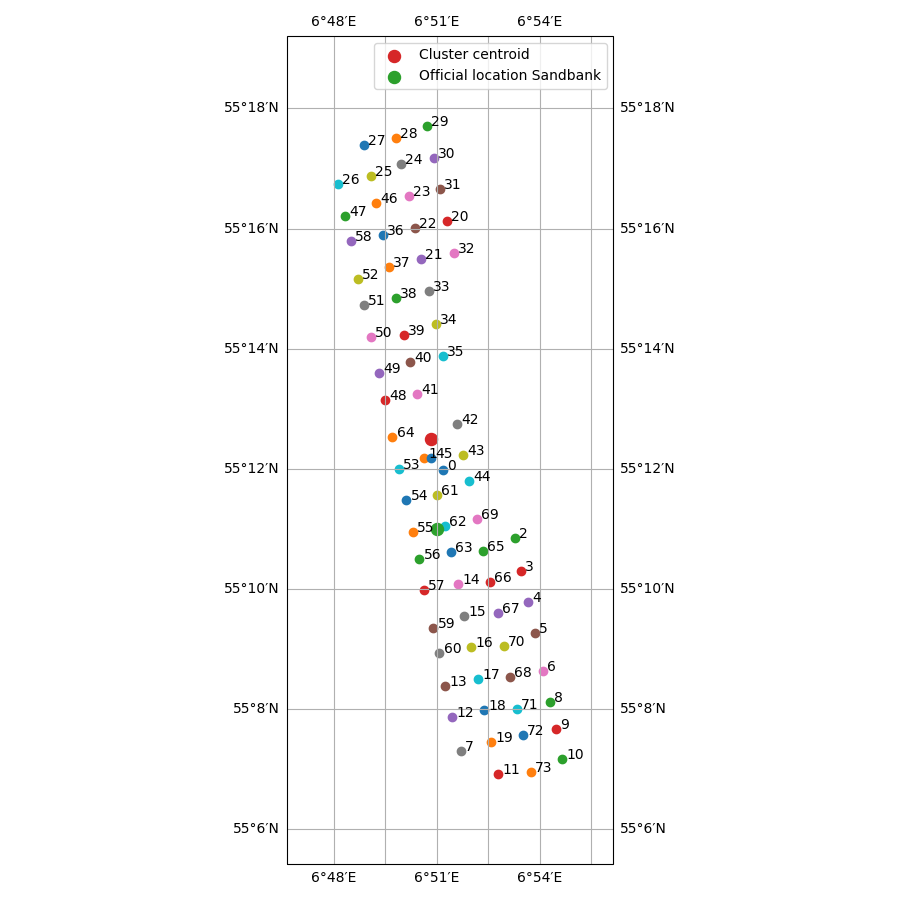

processing Rampion


<IPython.core.display.Javascript object>


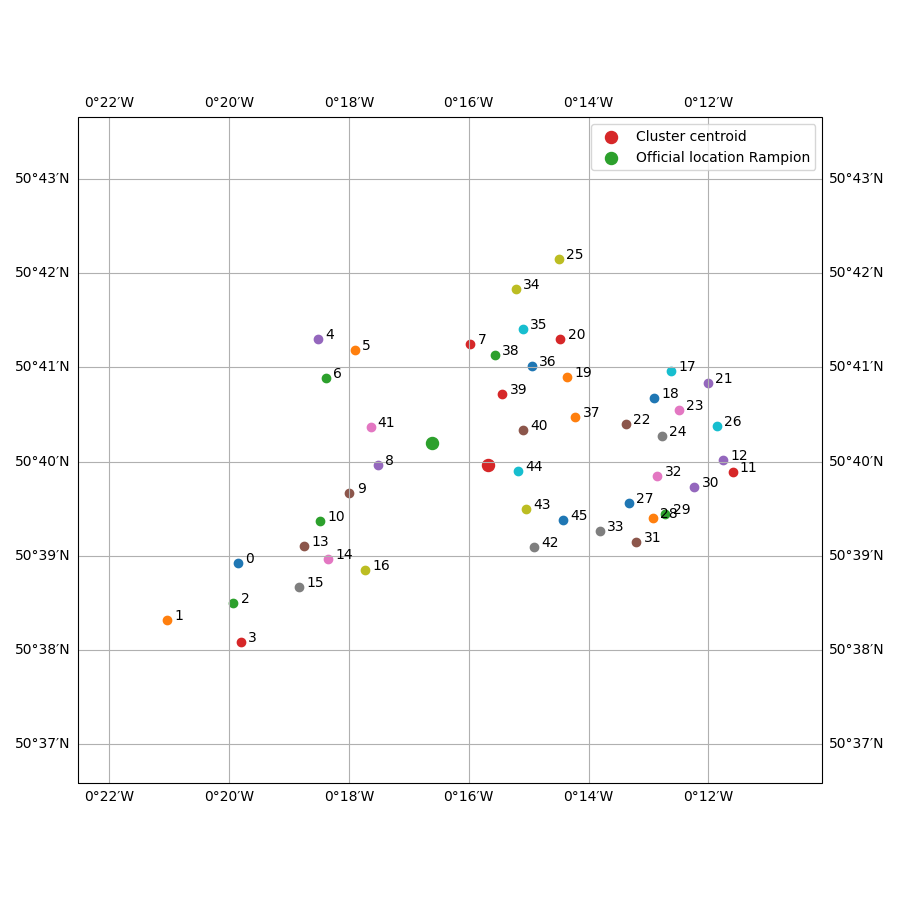

processing Teesside


<IPython.core.display.Javascript object>


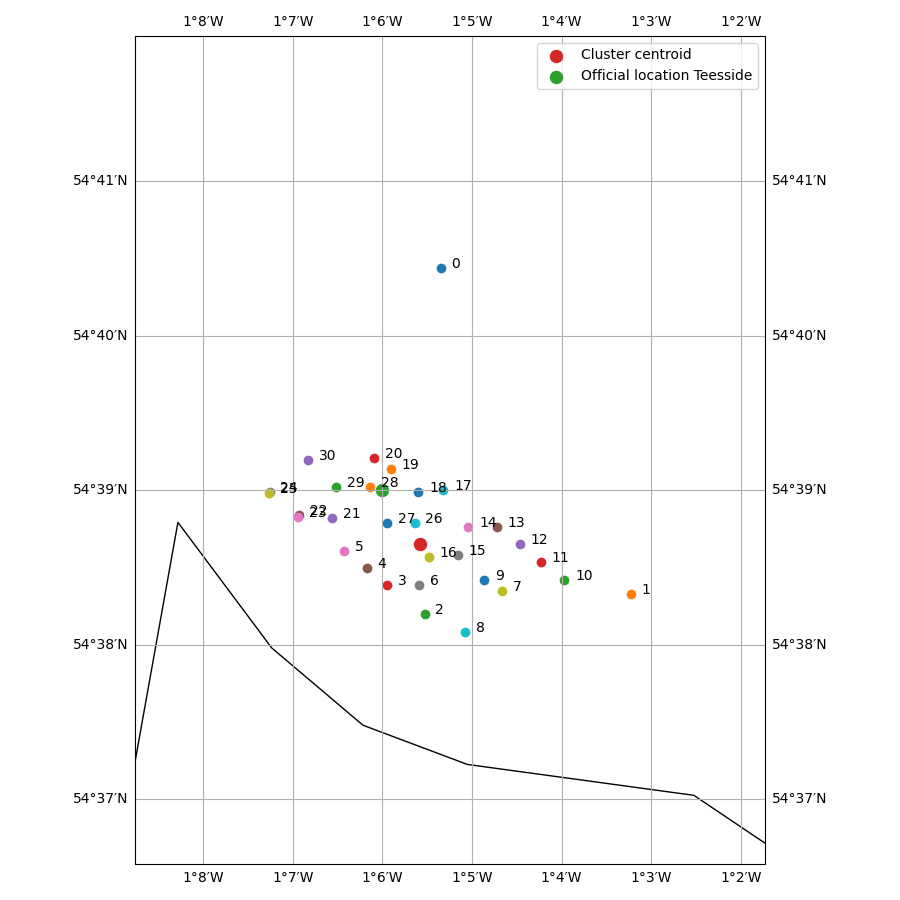

processing Moray East


<IPython.core.display.Javascript object>


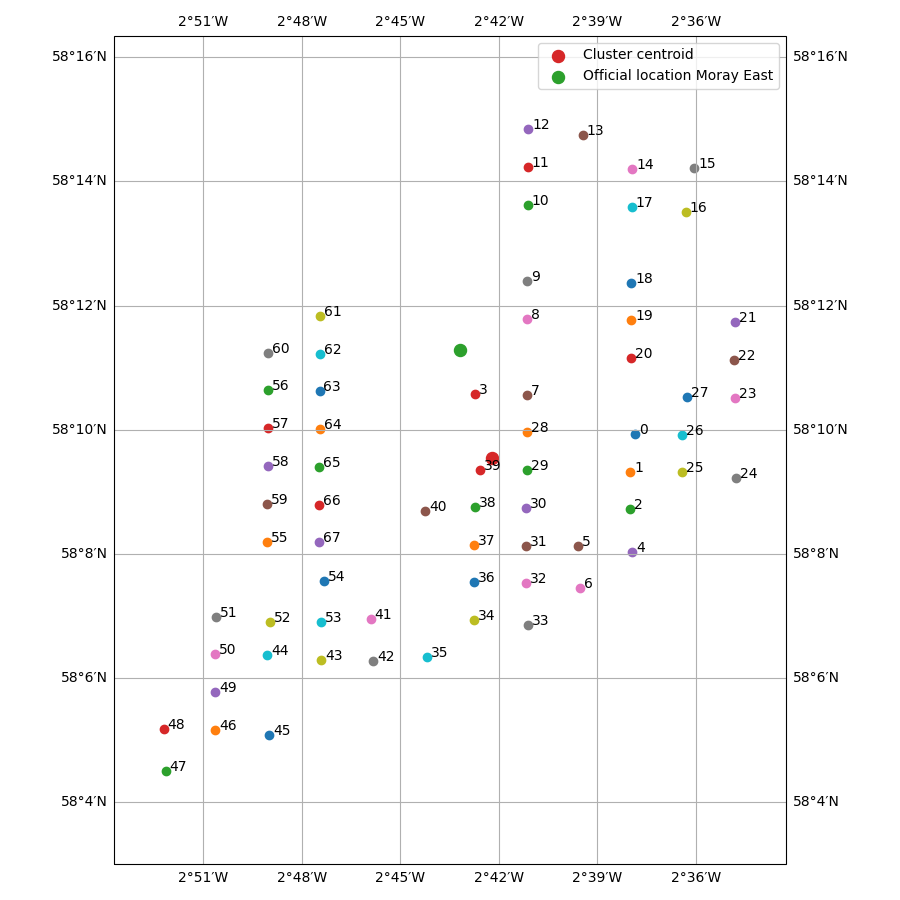

processing Wikinger


<IPython.core.display.Javascript object>


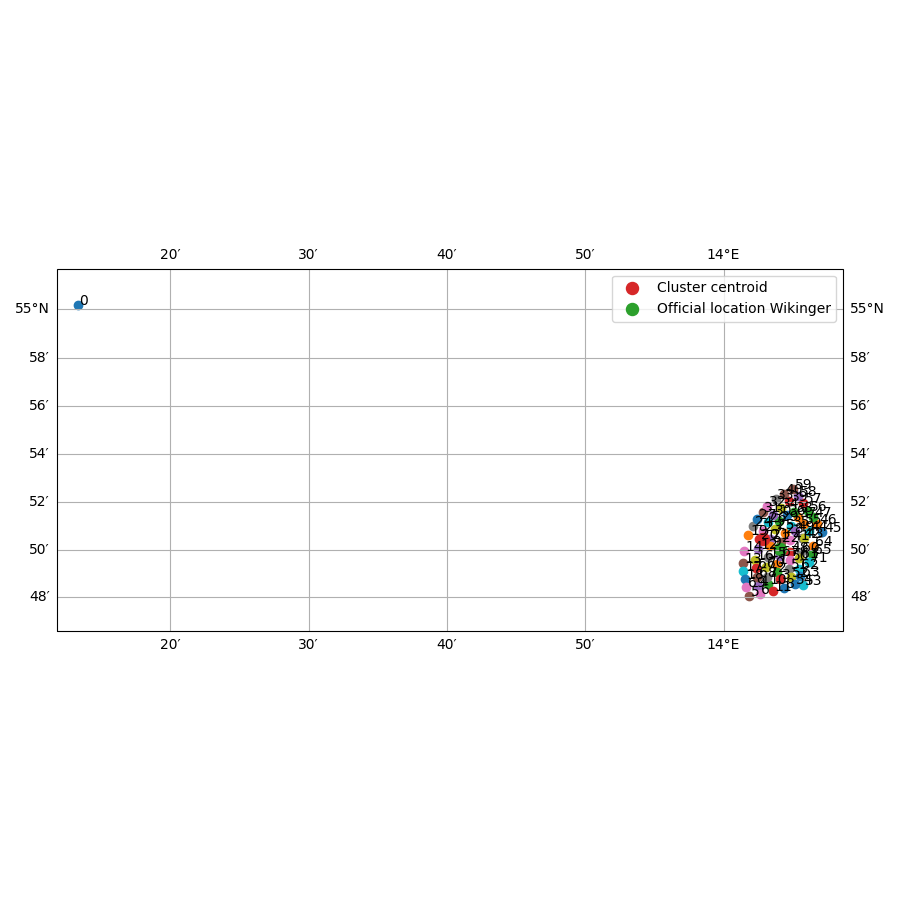

processing Galloper


<IPython.core.display.Javascript object>


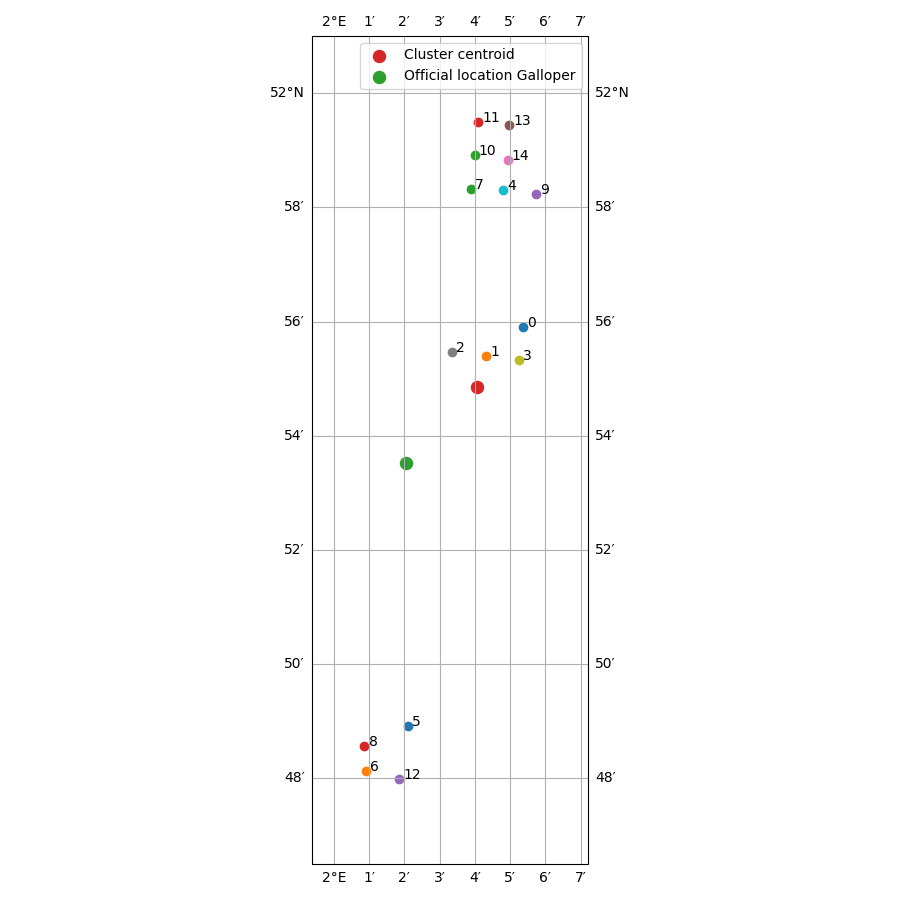

processing Borkum Riffgrund 2


<IPython.core.display.Javascript object>


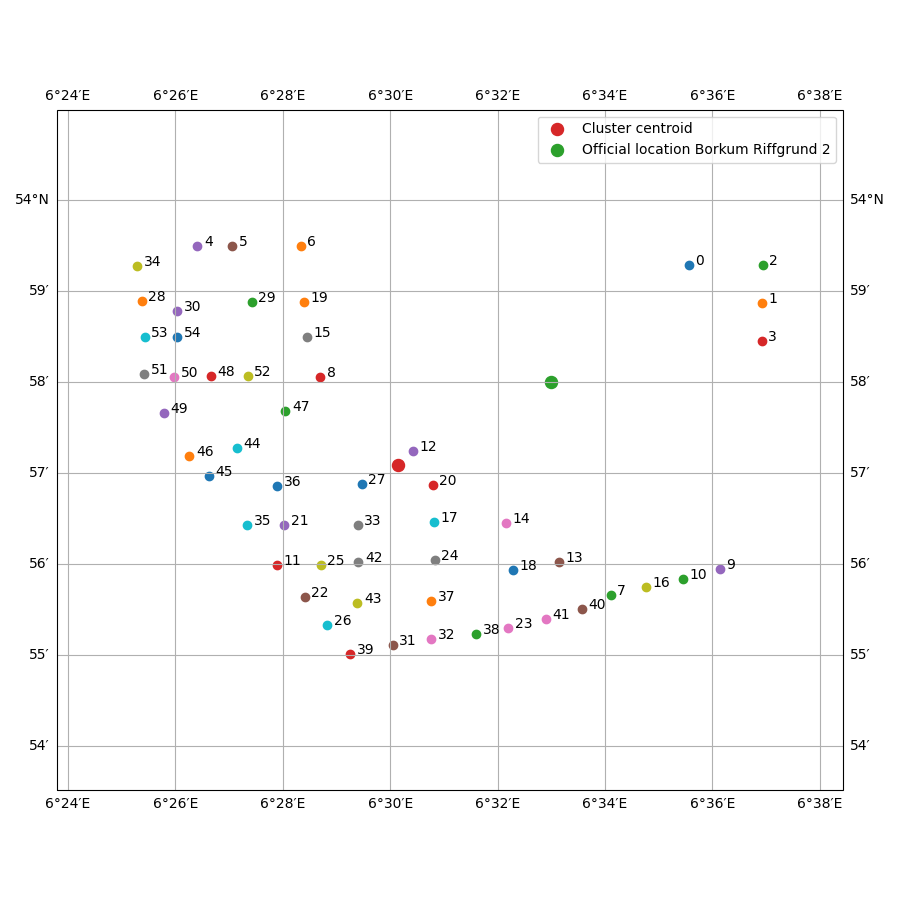

processing Veja Mate


<IPython.core.display.Javascript object>


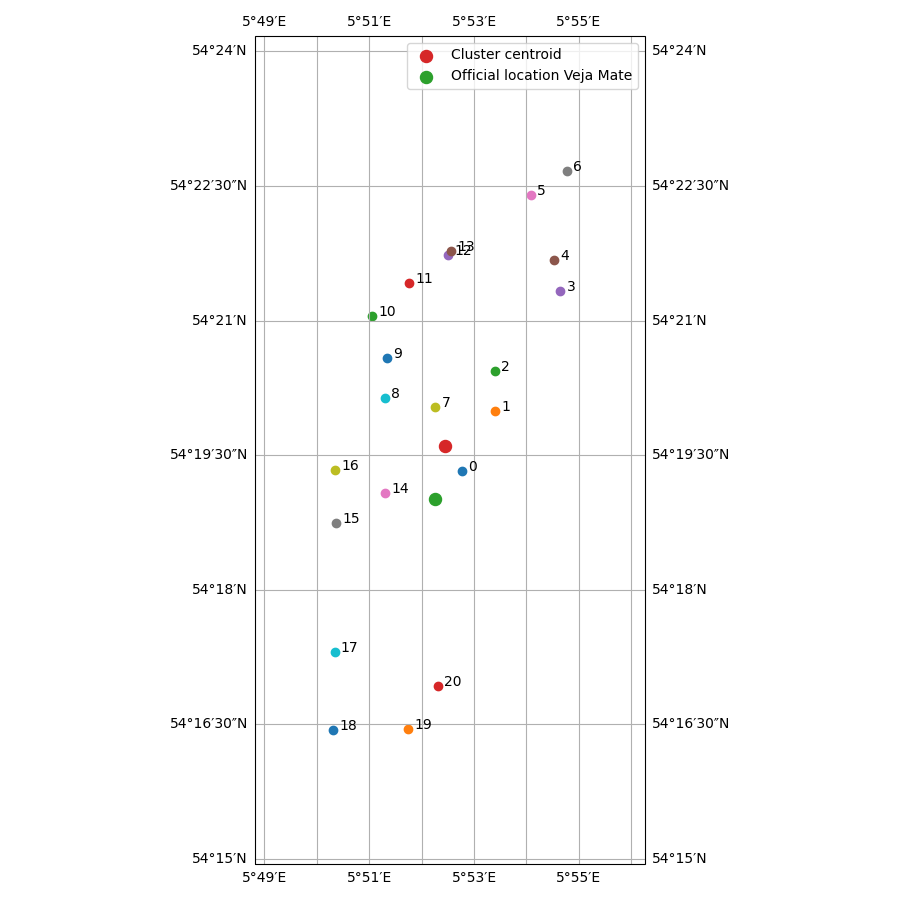

processing Global Tech I


<IPython.core.display.Javascript object>


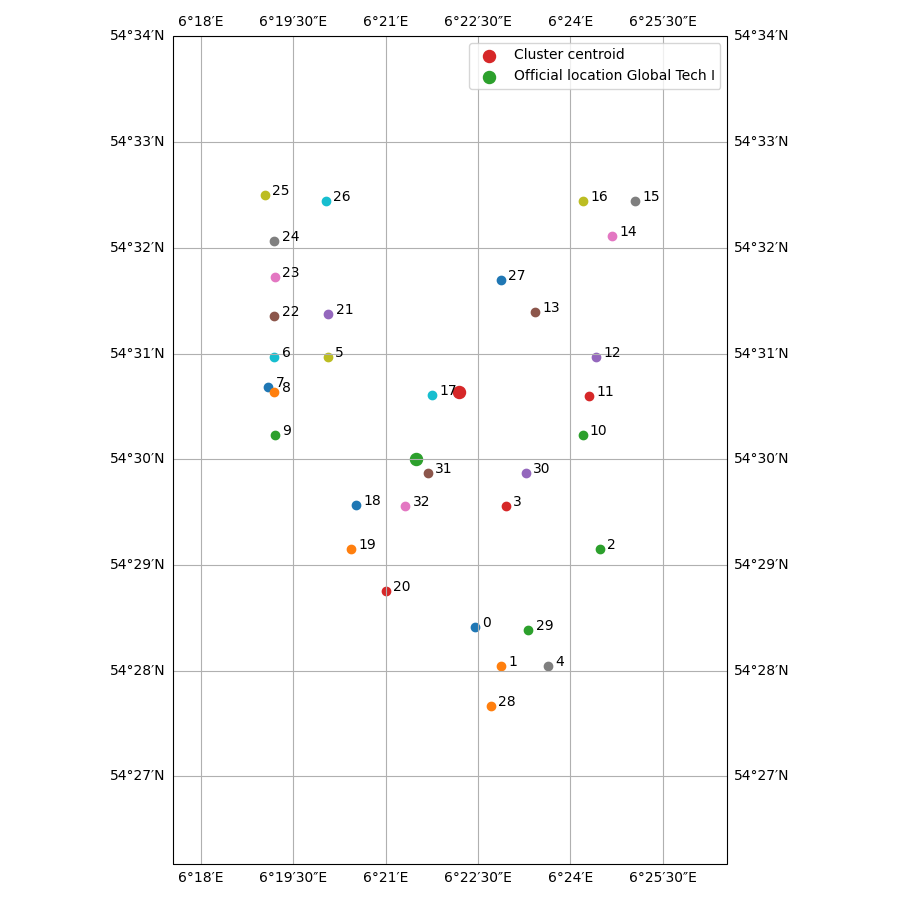

processing EnBW Baltic II (MP)


<IPython.core.display.Javascript object>


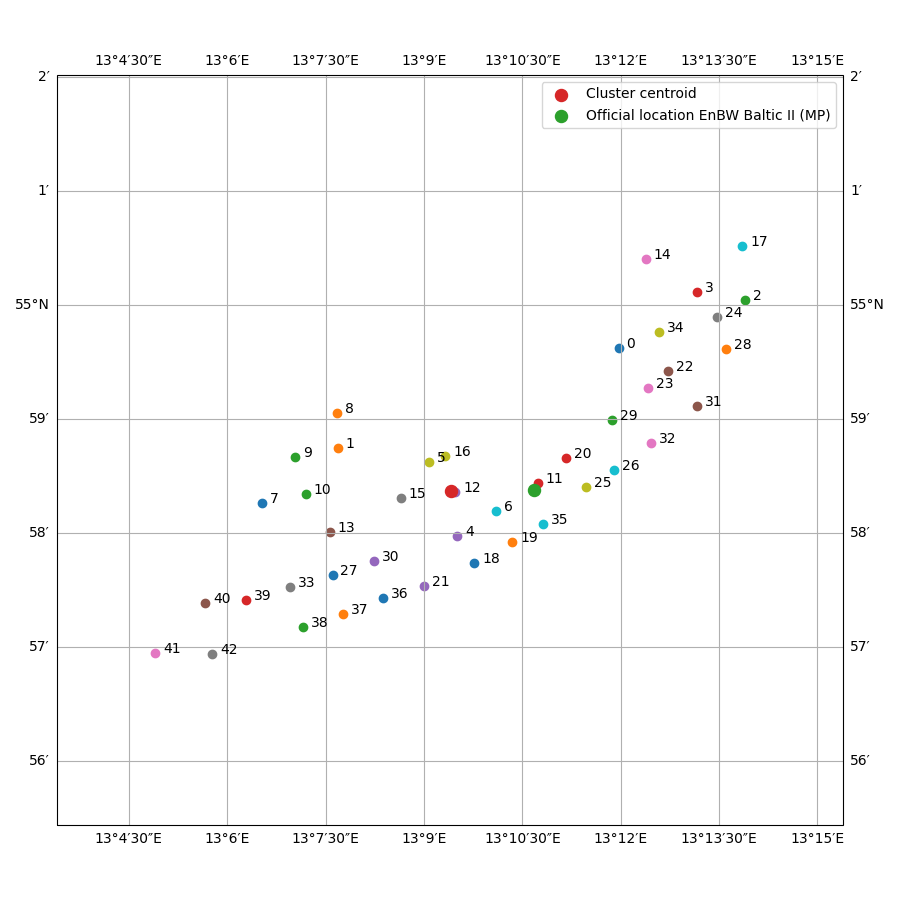

processing Nobelwind


<IPython.core.display.Javascript object>


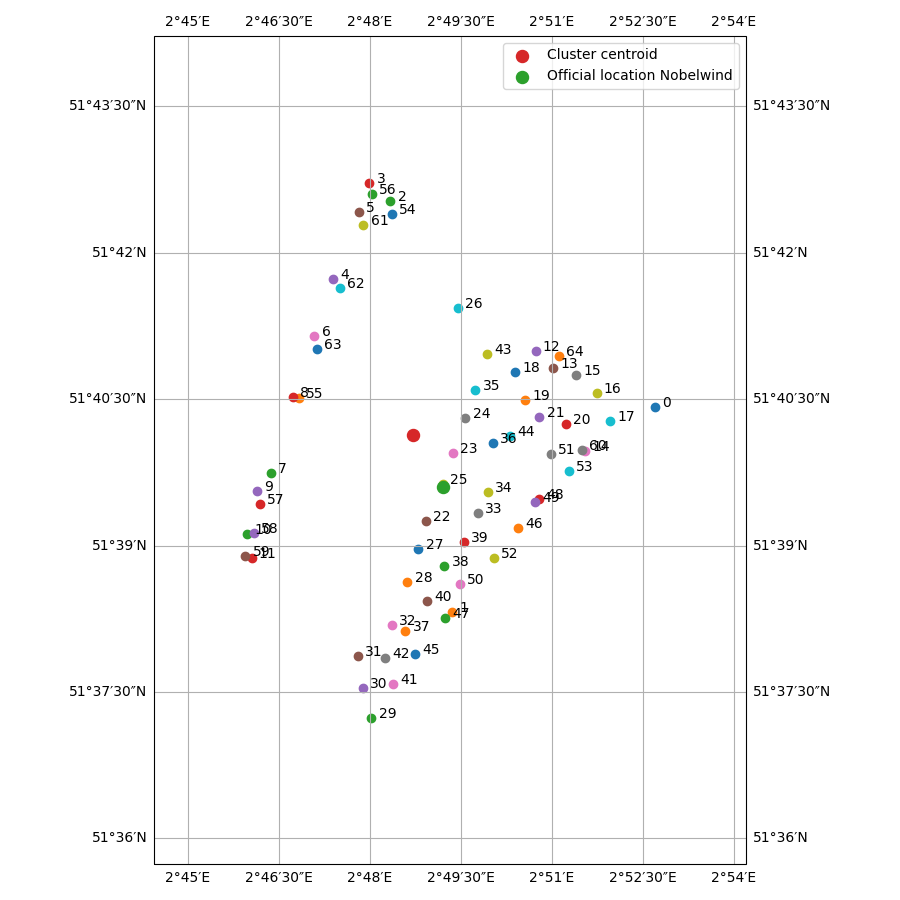

processing Northwind


<IPython.core.display.Javascript object>


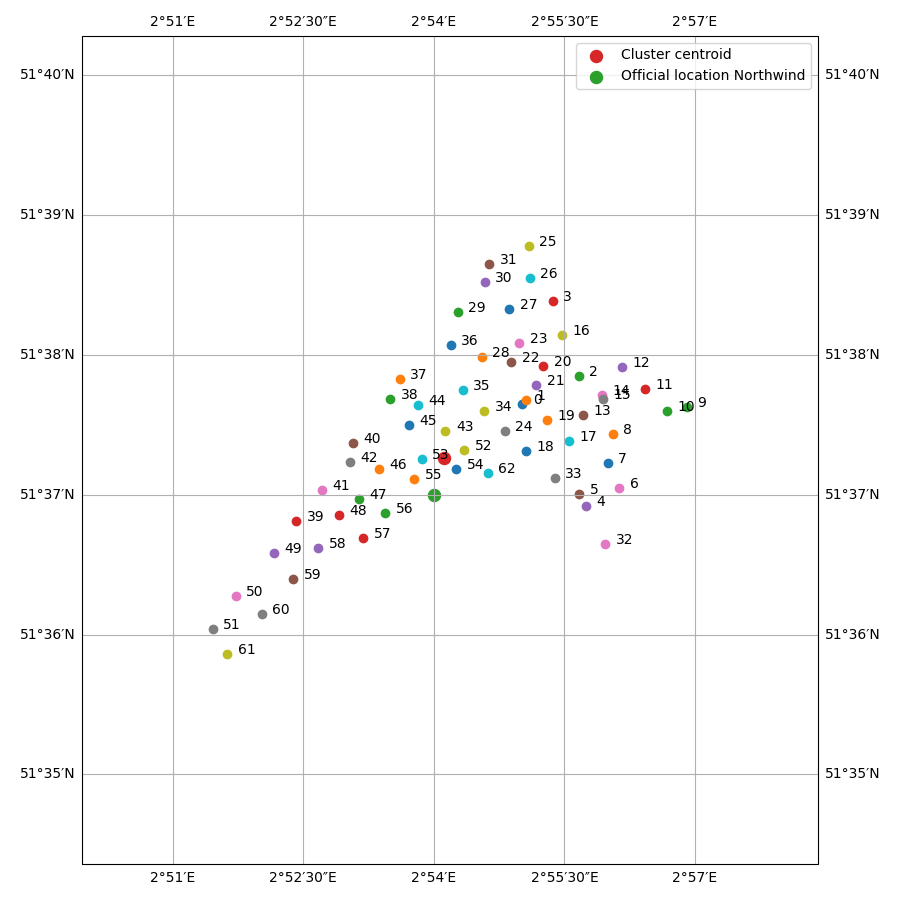

processing Lincs


<IPython.core.display.Javascript object>


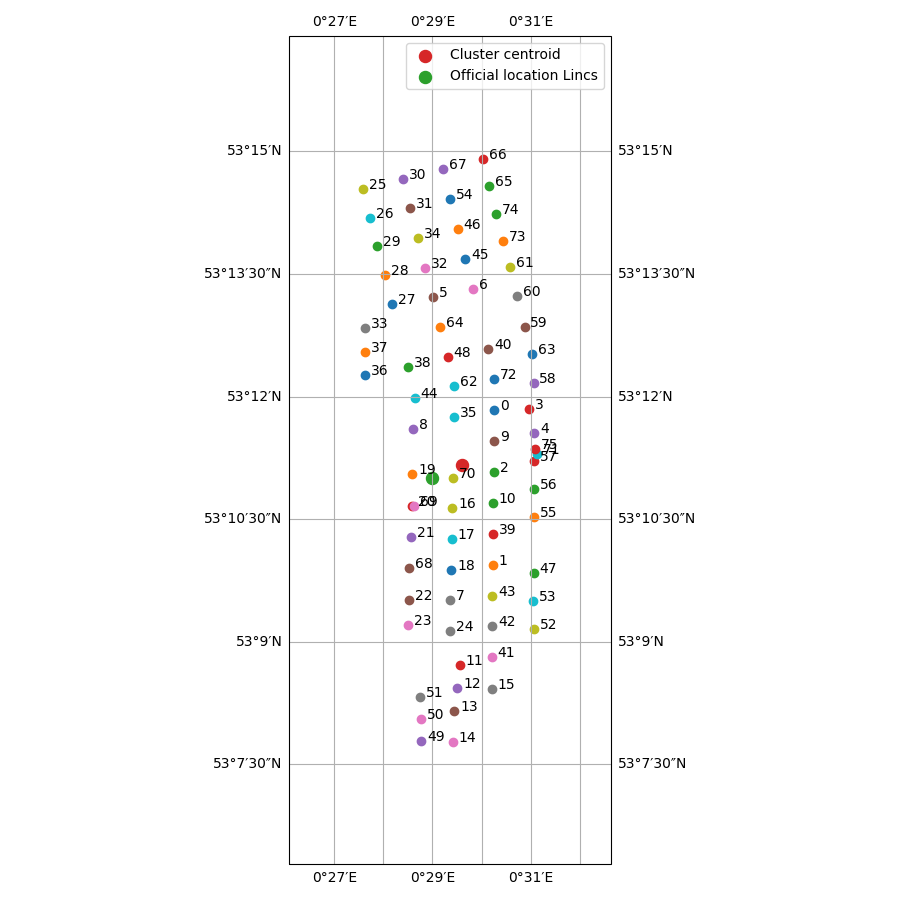

processing Lynn & Inner Dowsing


<IPython.core.display.Javascript object>


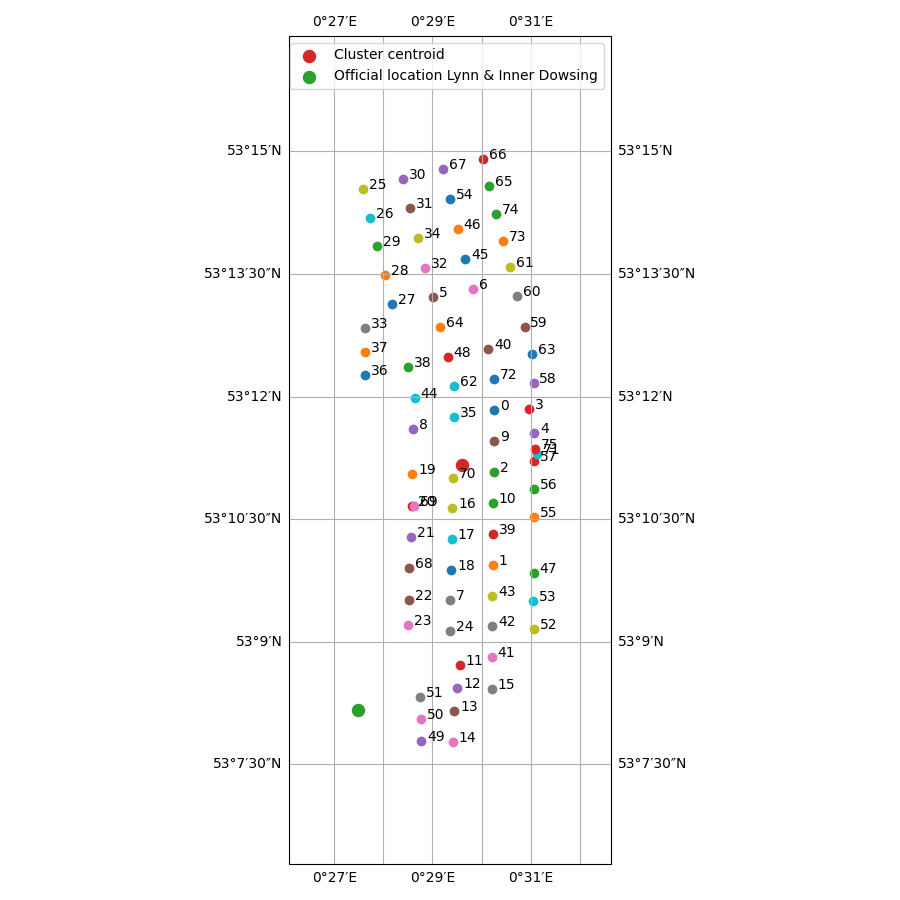

processing Humber Gateway


<IPython.core.display.Javascript object>


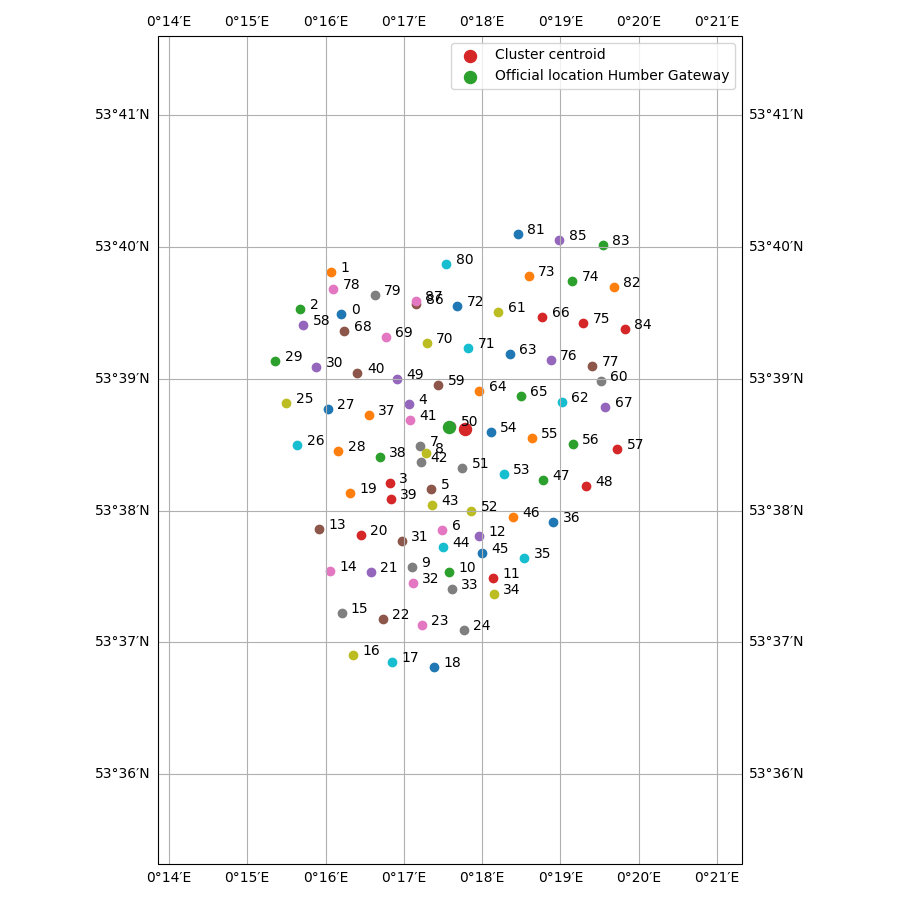

processing Kriegers Flak


<IPython.core.display.Javascript object>


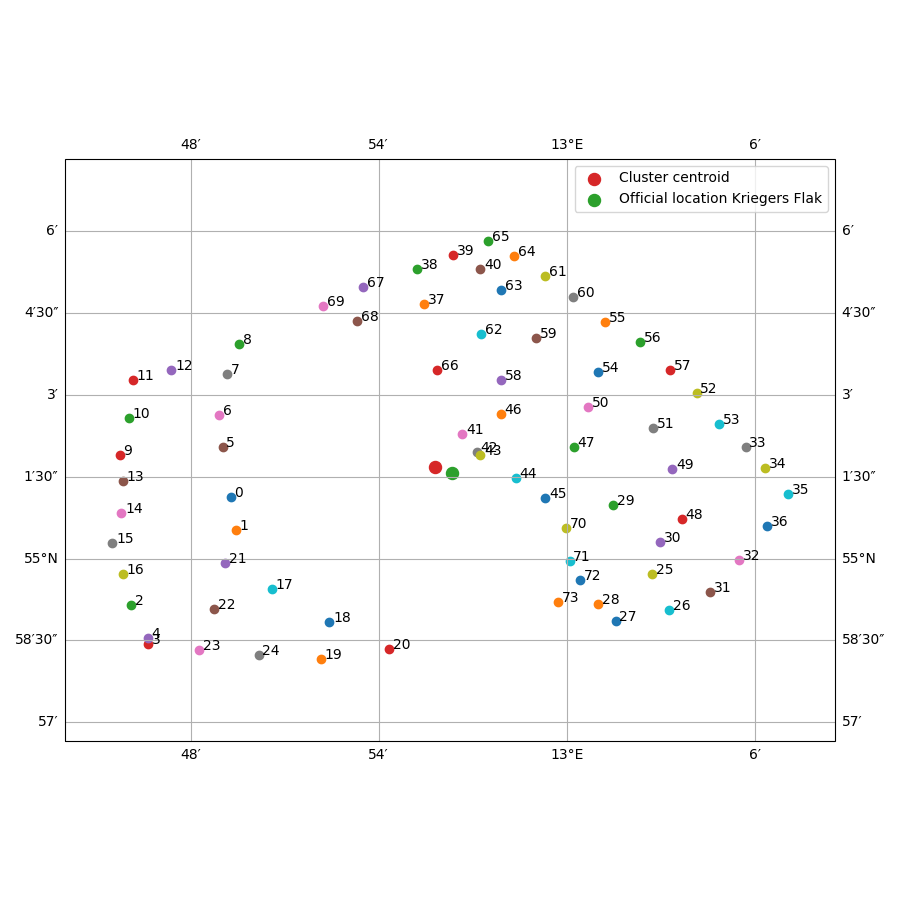

processing Nobelwind


<IPython.core.display.Javascript object>


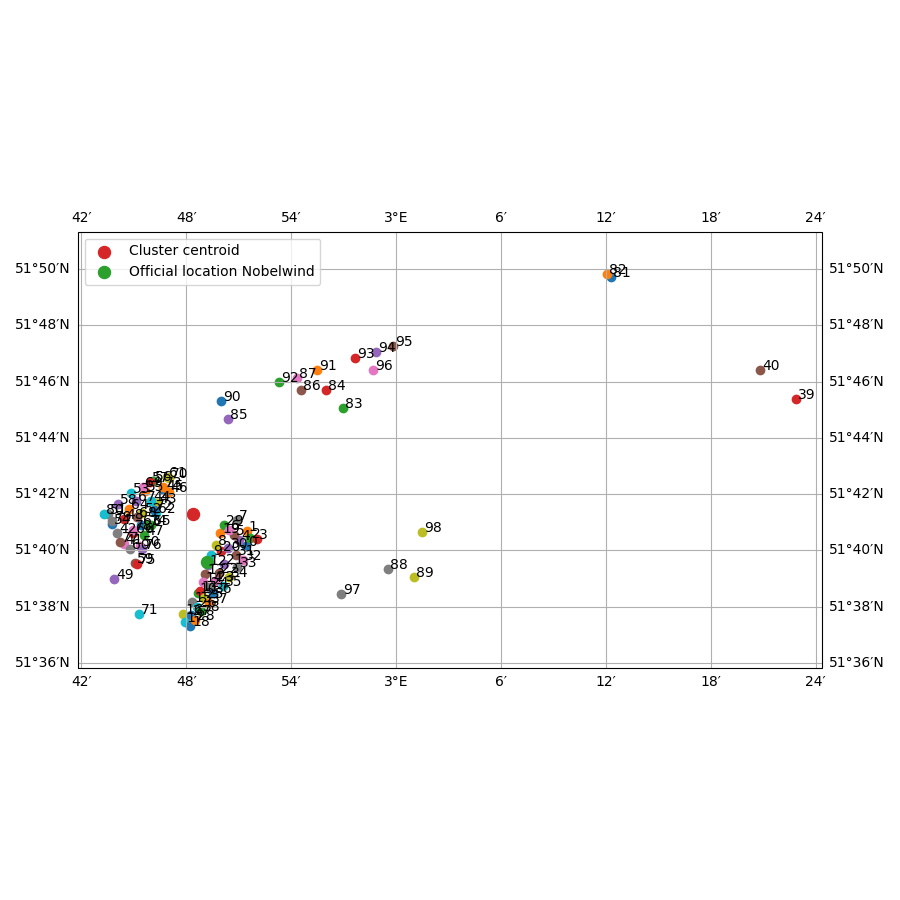

processing Northwester 2


<IPython.core.display.Javascript object>


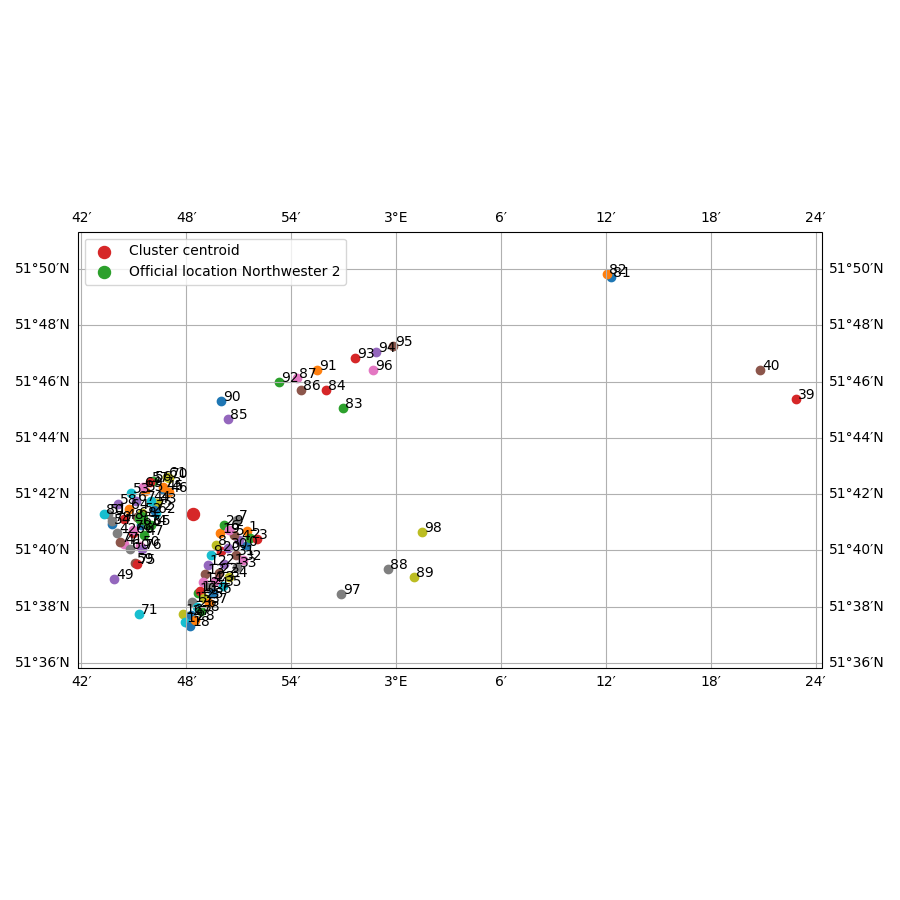

processing Borssele I/II


<IPython.core.display.Javascript object>


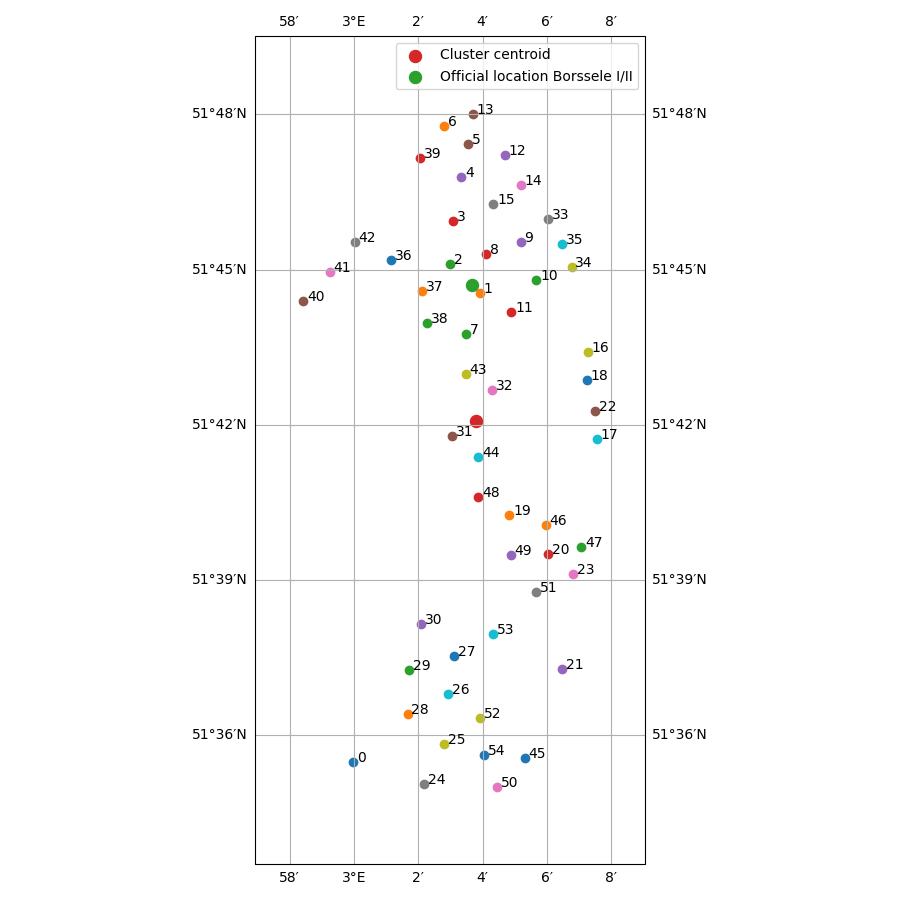

processing Hornsea


<IPython.core.display.Javascript object>


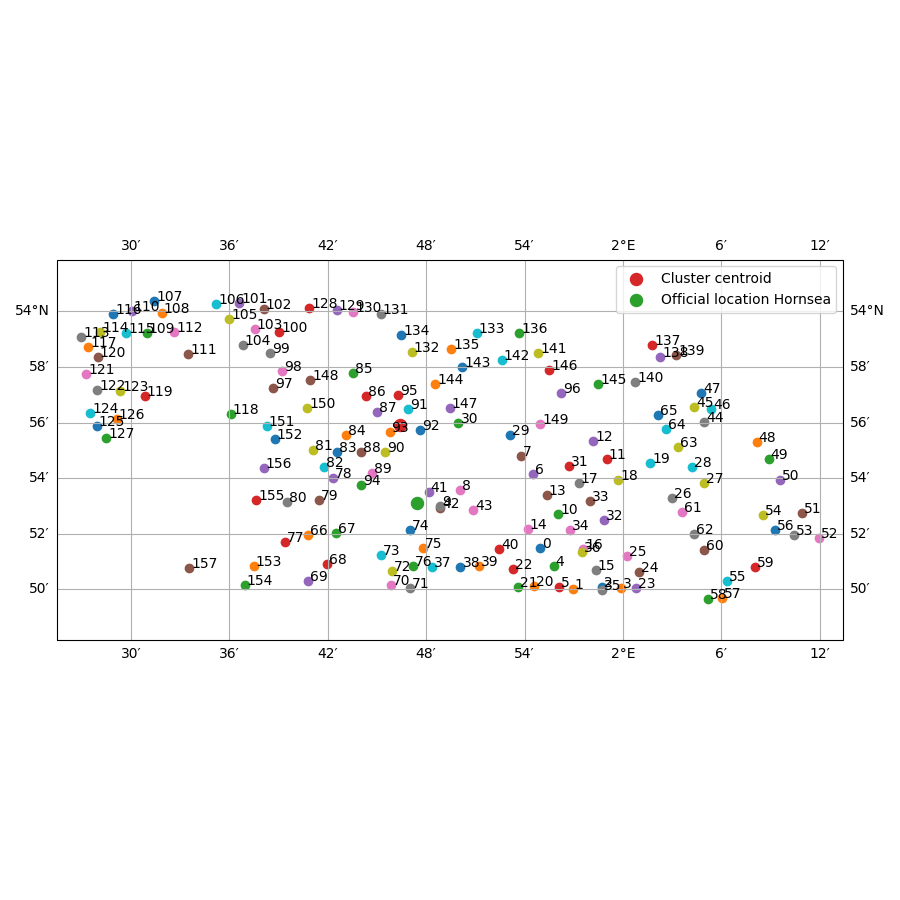

processing Dudgeon


/tmp/ipykernel_182113/1065959064.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure = plt.figure(figsize=figsize)


<IPython.core.display.Javascript object>


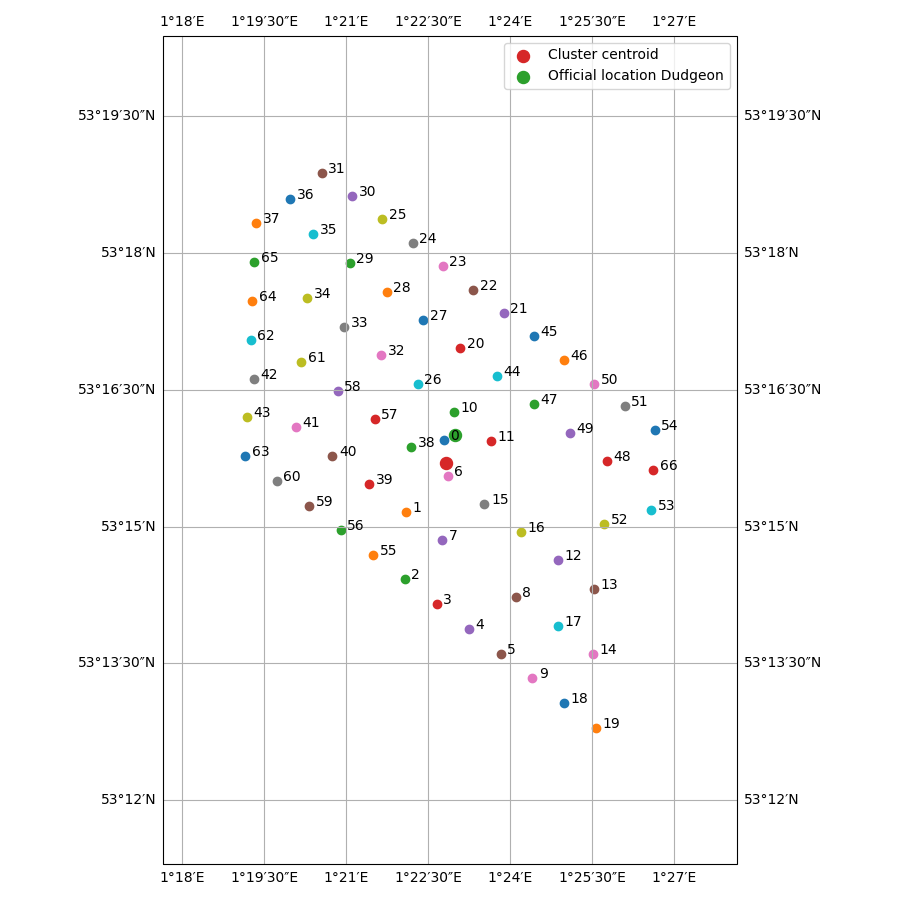

processing Arkona


<IPython.core.display.Javascript object>


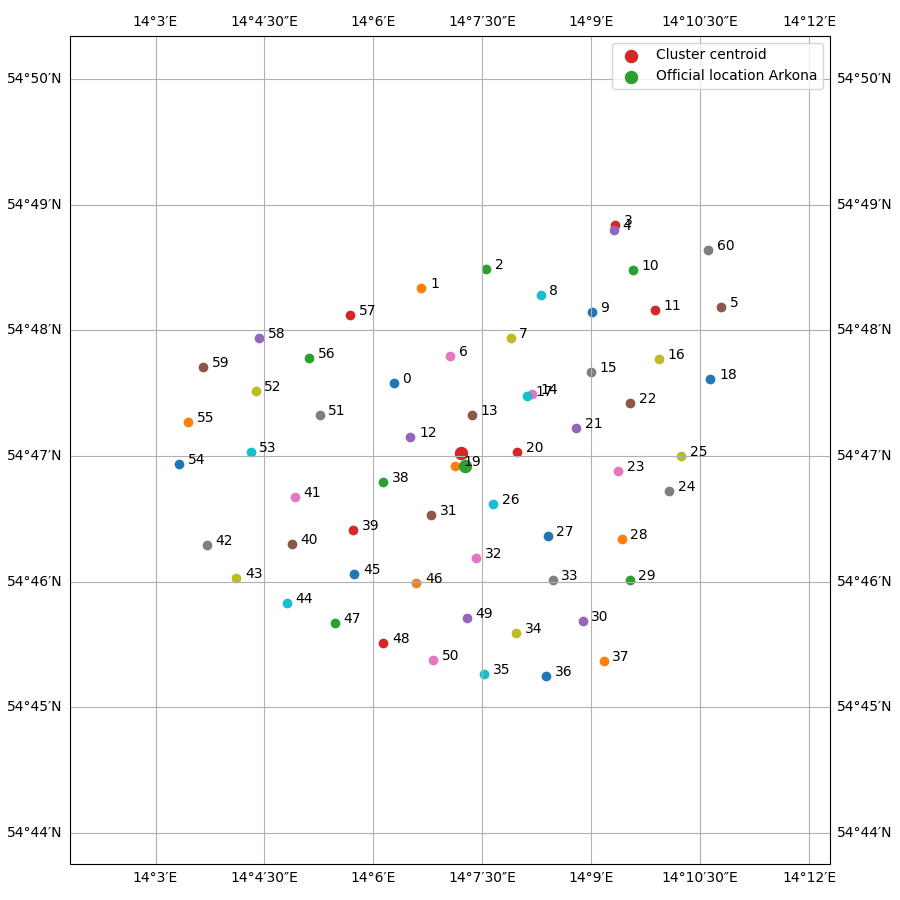

processing Gode Wind I & II


<IPython.core.display.Javascript object>


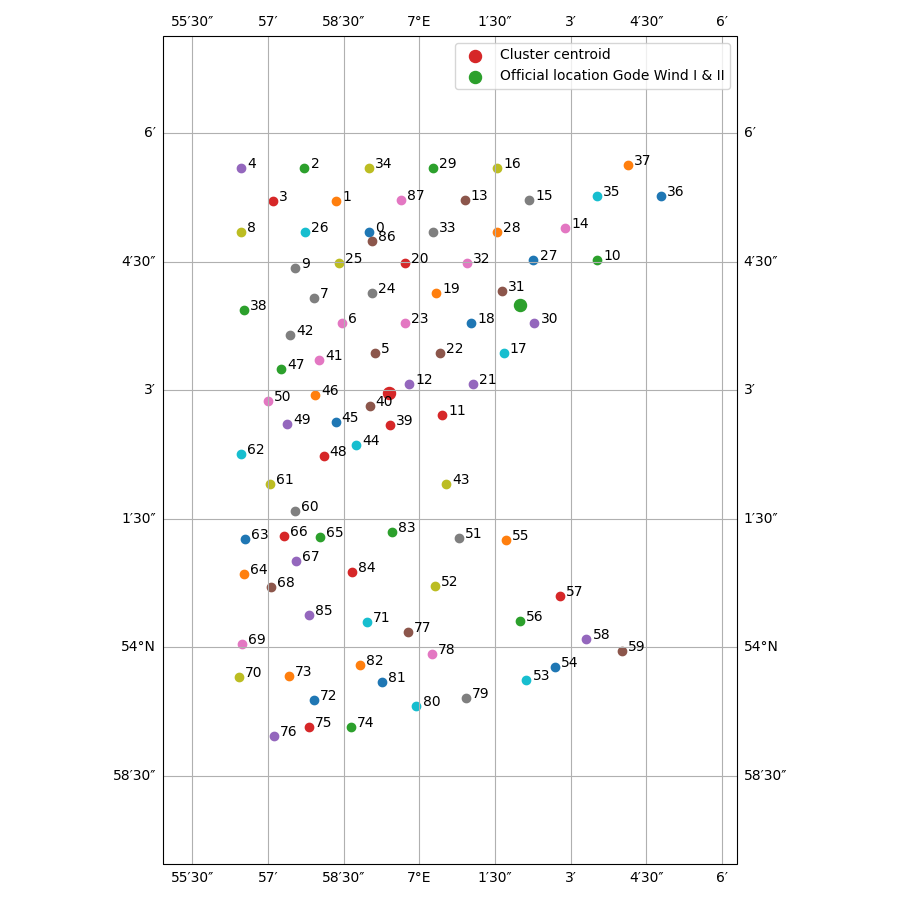

processing Westermost Rough


<IPython.core.display.Javascript object>


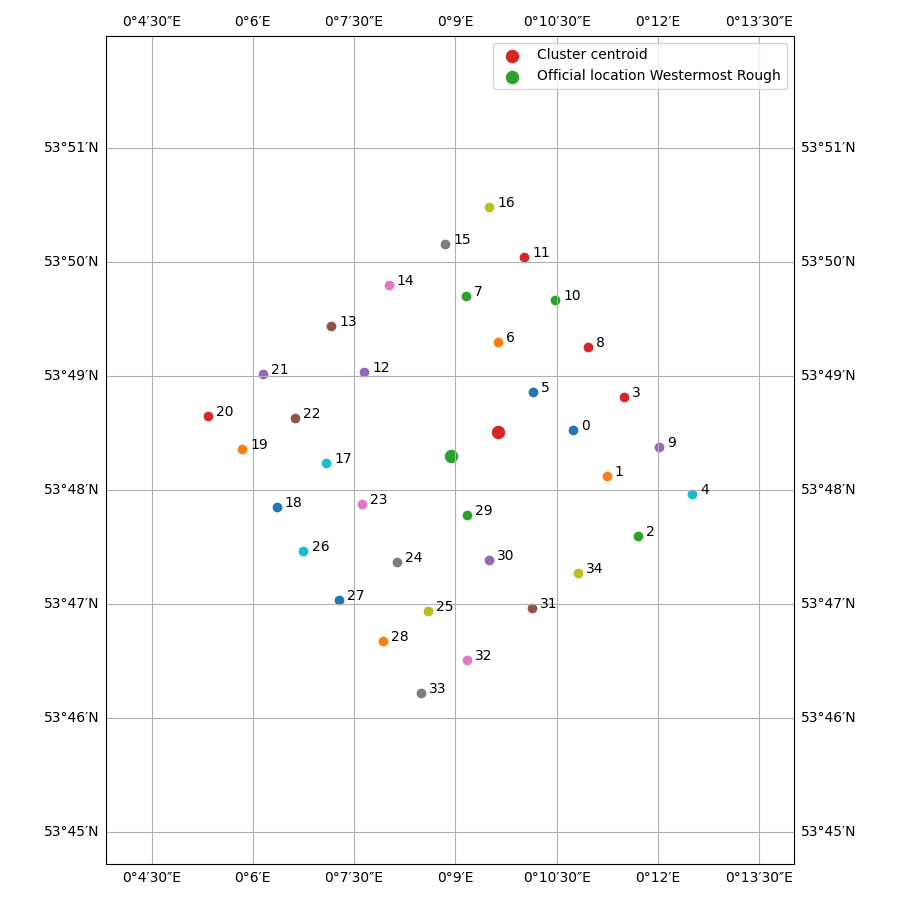

processing Merkur


<IPython.core.display.Javascript object>


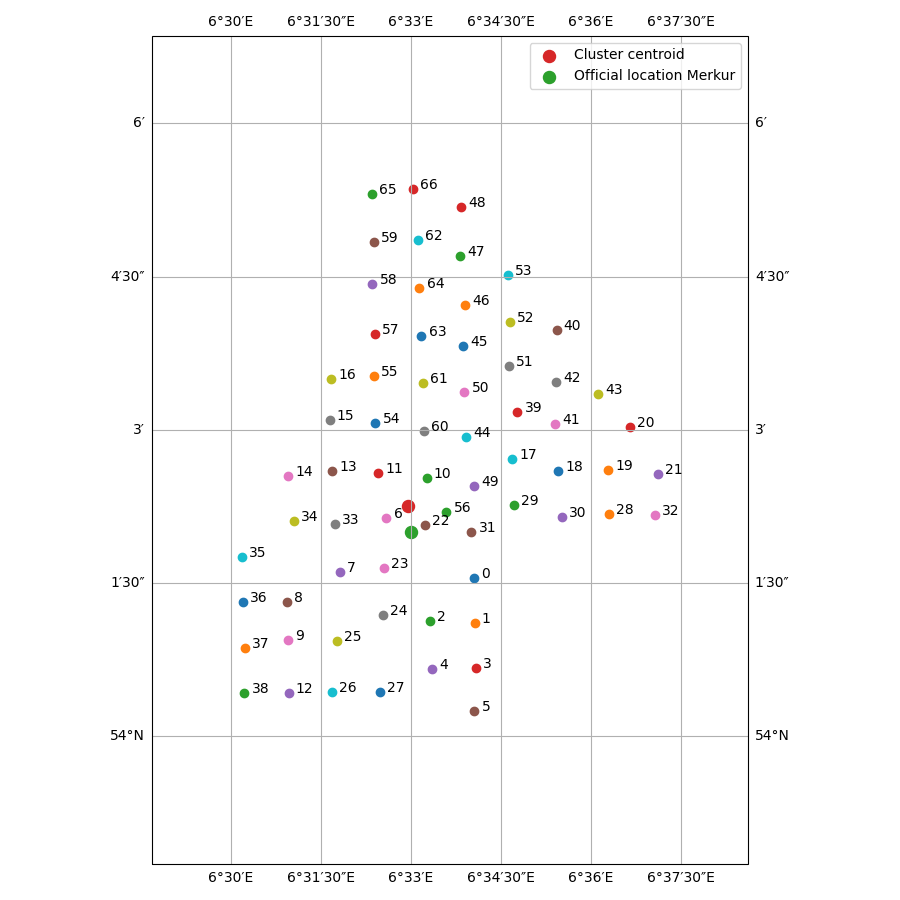

processing Trianel Borkum 2


<IPython.core.display.Javascript object>


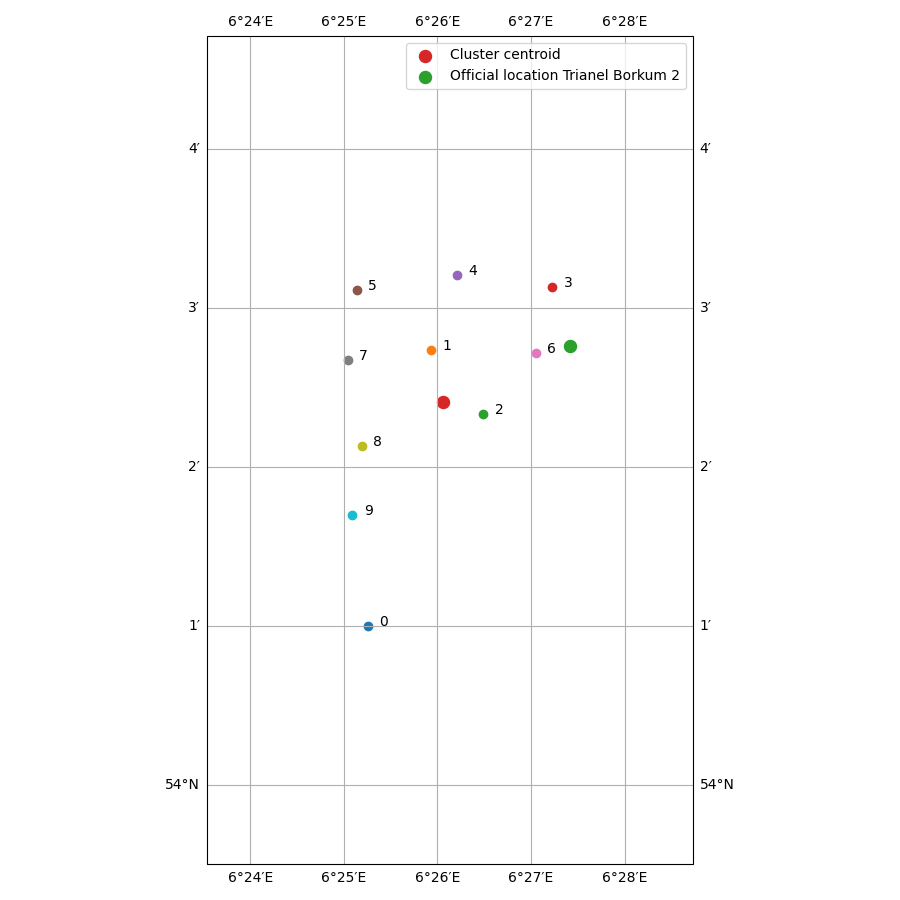

processing Global Tech I


<IPython.core.display.Javascript object>


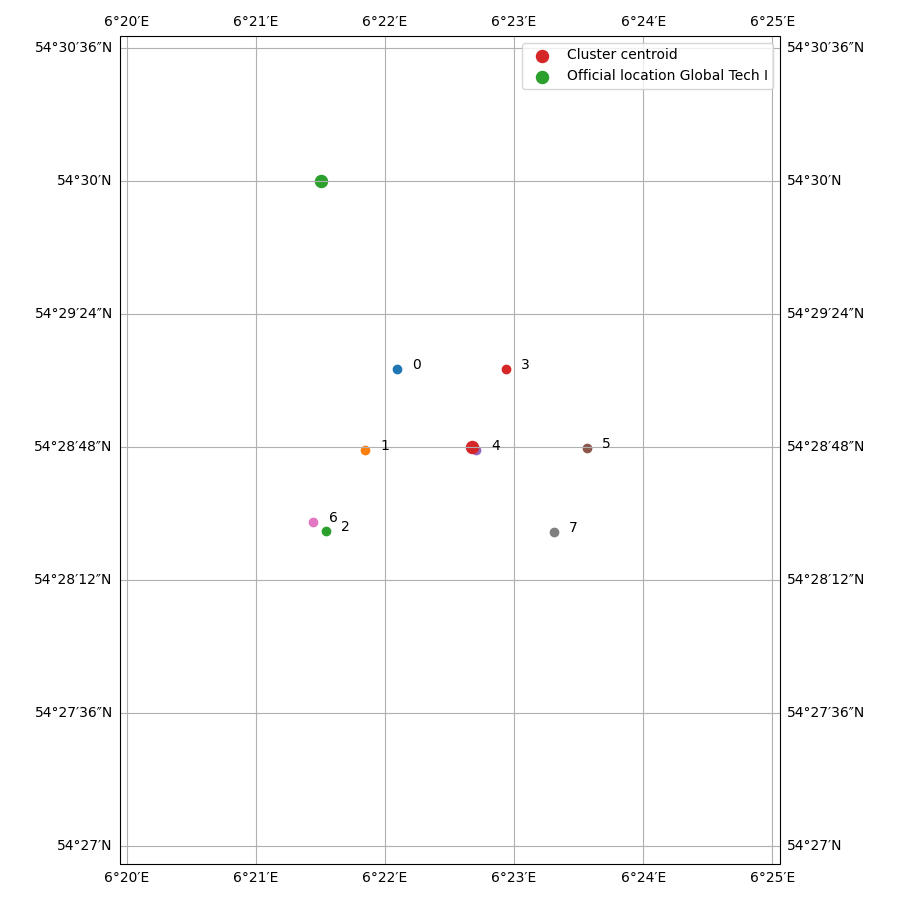

processing BARD Oﬀshore I


<IPython.core.display.Javascript object>


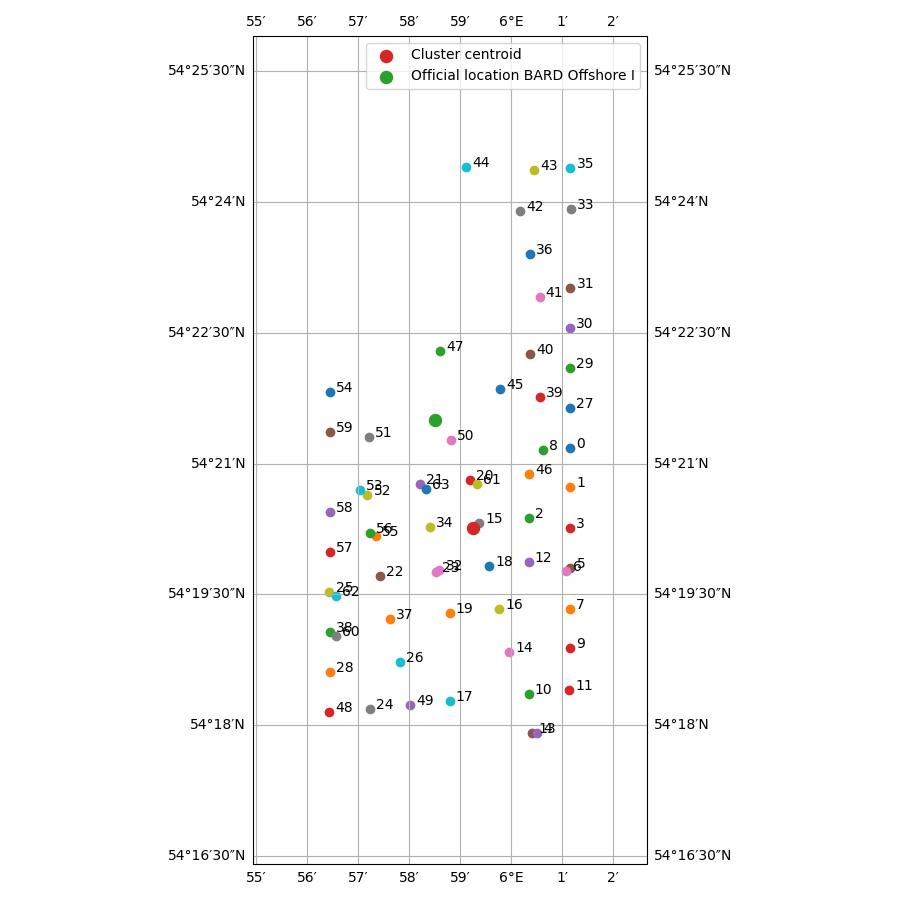

processing Norther


<IPython.core.display.Javascript object>


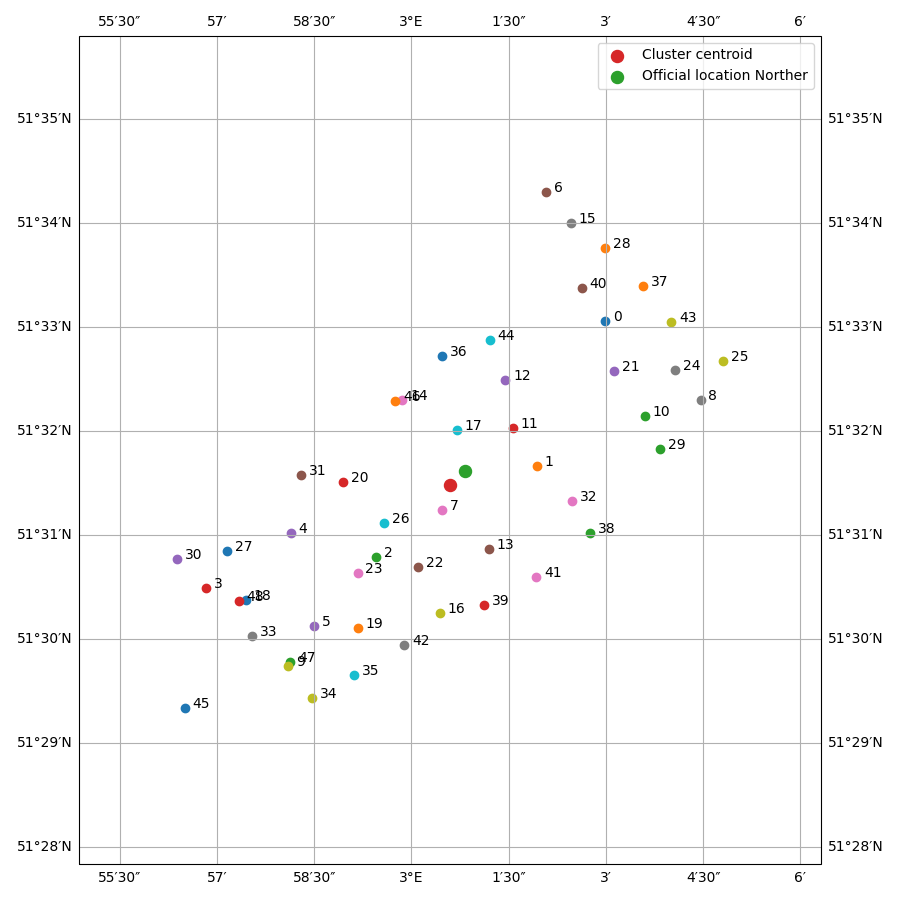

processing Gemini


<IPython.core.display.Javascript object>


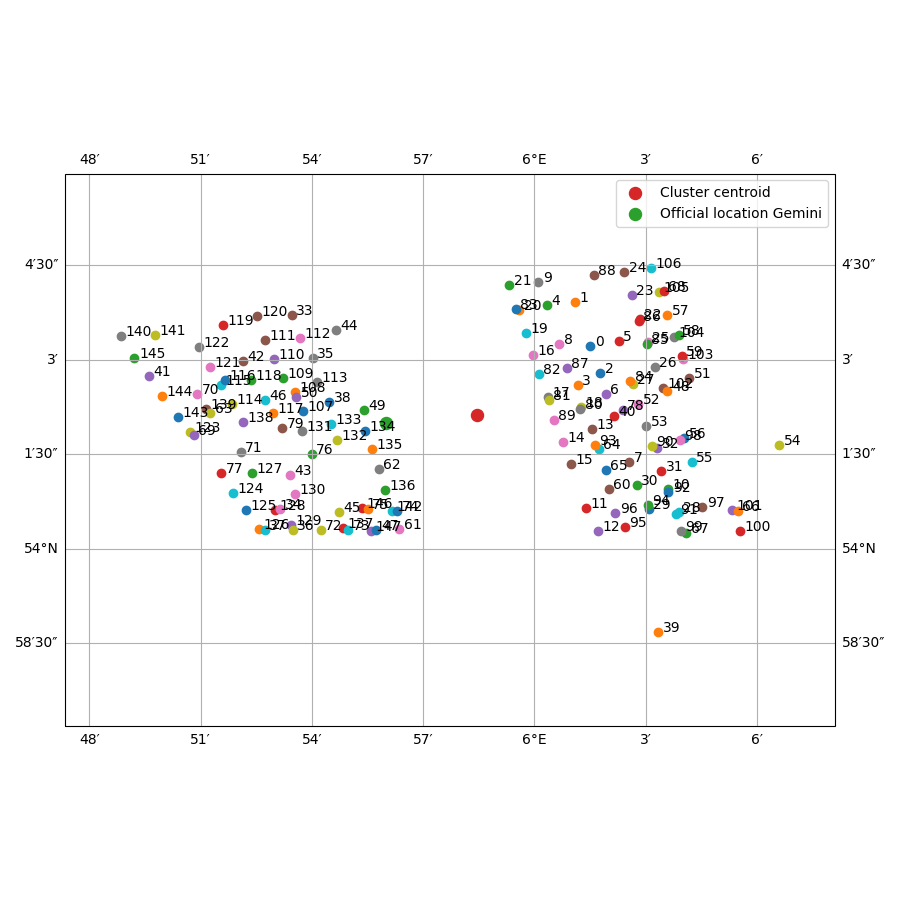

processing Luchterduinen


<IPython.core.display.Javascript object>


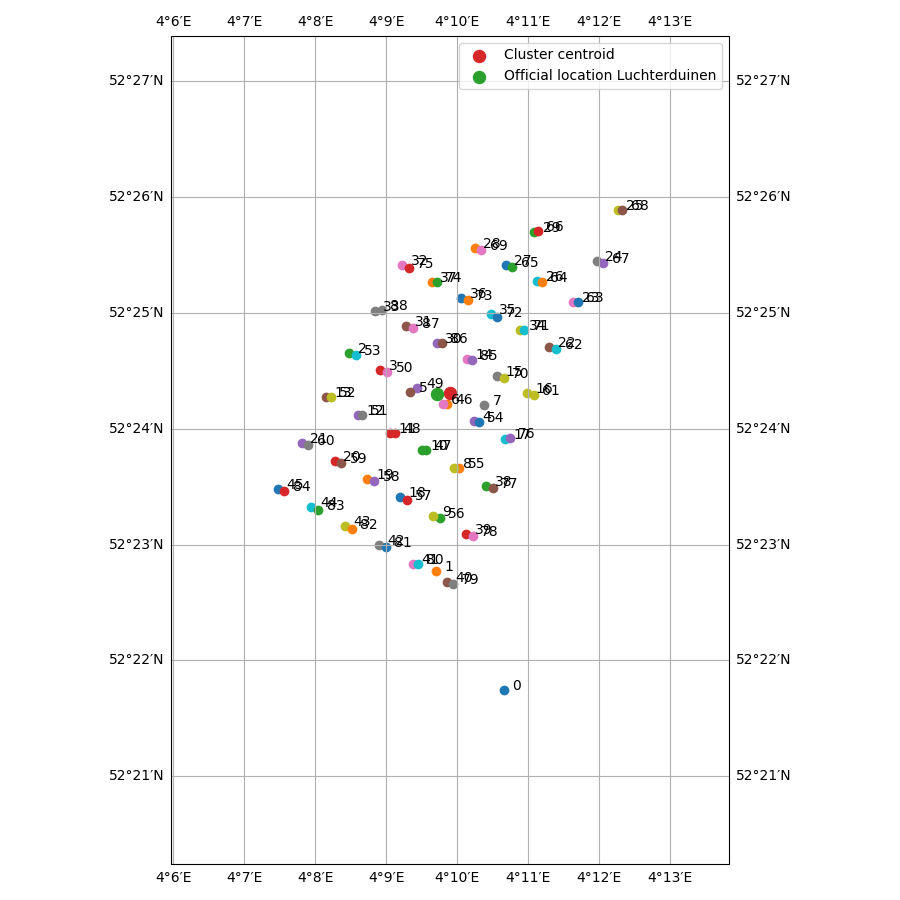

In [63]:
for index, locations in identified_windfarms.items():
    windfarm_name = matching_windfarms.windfarm_name[index]
    print(f"processing {windfarm_name}")
    plot_cluster_locations(locations, matching_windfarms.loc[index], known_windfarms=known_windfarms)

In [12]:
identified_windfarms

{0:    location_key   latitude  longitude                     start  \
 0    location_0  55.199839   6.853092 2016-05-11 05:16:52+00:00   
 1    location_1  55.203178   6.843873 2016-06-03 16:09:10+00:00   
 2   location_10  55.119331   6.910699 2016-08-16 16:13:03+00:00   
 3   location_11  55.115156   6.879788 2016-08-17 18:00:01+00:00   
 4   location_12  55.130982   6.857523 2016-08-18 17:26:18+00:00   
 ..          ...        ...        ...                       ...   
 69  location_71  55.133398   6.888968 2017-01-19 19:00:10+00:00   
 70  location_72  55.126121   6.891840 2017-01-20 12:17:44+00:00   
 71  location_73  55.115817   6.895708 2017-01-21 08:04:50+00:00   
 72   location_8  55.135268   6.904849 2016-08-14 04:10:30+00:00   
 73   location_9  55.127792   6.907808 2016-08-15 22:35:52+00:00   
 
                          end         duration  
 0  2016-06-01 15:20:02+00:00 21 days 10:03:10  
 1  2016-06-04 12:13:28+00:00  0 days 20:04:18  
 2  2016-08-17 16:21:25+00:00  1

In [13]:
for i, j in combinations(locations, 2):
    print(haversine((locations[i]['lat_mean'], locations[i]['lon_mean']), (locations[j]['lat_mean'], locations[j]['lon_mean'])))

KeyError: 'lat_mean'

---

# Cluster plots

In [ ]:
basedir = "../../data/marinetraffic/clustered/"
for _, matching_windfarm in matching_windfarms.iterrows():
    clusterpath = os.path.join(os.path.join(os.path.join(basedir, matching_windfarm.vesselname), matching_windfarm.clustername), f"{matching_windfarm.vesselname}_{matching_windfarm.clustername}.csv")
    if not os.path.isfile(clusterpath):
        print(f"no such file or directory: {clusterpath}")
    cluster = pd.read_csv(clusterpath)
    plot_cluster(cluster, windfarms.loc[matching_windfarm.windfarm_index], label=f'{matching_windfarm.vesselname} {matching_windfarm.clustername}', show_fig=True)